# 🔮 Prédiction de revenus

Une banque souhaite acquérir de nouveaux clients à travers le monde, plus particulièrement des jeunes en âge d'ouvrir leur premier compte bancaire. Pour cibler les individus susceptibles d'avoir à l'avenir de hauts revenus, on va donc créer un modèle permettant de déterminer le revenu potentiel d'une personne.

Pour chaque pays dans le monde, on ne disposera à la base que du revenu des actifs, du revenu moyen et de l'indice de Gini.

On abordera les modélisations de type ANOVA et régression linéaire, en se limitant aux seules variables à notre disposition :
- le revenu des parents (on ciblera les enfants des clients actuels)
- le revenu moyen du pays dans lequel habite le prospect
- l'indice de Gini calculé sur les revenus des habitants du pays en question

**Sommaire**

- [Exploration](#Exploration)
- [Analyse](#Analyse)
- [Génération de la classe parent](#Génération-de-la-classe-parent)
- [Modélisation](#Modélisation)
- [Résumé](#Résumé)

In [652]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [653]:
palette = ['#d50000', '#6200ea', '#0091ea', '#00c853', '#ffd600'] # Palette de couleurs
sns.set(style='white', context='notebook', palette=palette) # Styles Seaborn
def save_fig(file_name): # Fonction d'export des graphiques
    return plt.savefig('graphiques/' + file_name, dpi=150, bbox_inches='tight')

# Exploration

## Données

Le premier jeu est fourni par la [Banque mondiale](https://fr.wikipedia.org/wiki/Banque_mondiale). Pour chaque pays présent, on dispose des quantiles (classes) de revenus de sa population.
- *year_survey* : l'année de l'étude
- *quantile* : la classe de revenu concernée
- *nb_quantiles* : le nombre de quantiles
- *income* : le revenu moyen des personnes appartenant à la classe de revenu correspondant au quantile. L'unité utilisée est le dollar PPP  (on parle de valeurs mesurées en parité de pouvoir d'achat). Cette unité est calculée par la Banque mondiale, selon la méthode Eltöte-Köves-Szulc.
- *gdpppp* : le PIB à parité du pouvoir d'achat (PPA) du pays

In [654]:
sources = 'sources/' # URL des jeux de données
df = pd.read_csv(sources + 'data-projet7.csv')
df

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297
3,ALB,2008,4,100,"1086,9078",7297
4,ALB,2008,5,100,"1132,6997",7297
...,...,...,...,...,...,...
11594,COD,2008,96,100,"810,6233","303,19305"
11595,COD,2008,97,100,"911,7834","303,19305"
11596,COD,2008,98,100,"1057,8074","303,19305"
11597,COD,2008,99,100,"1286,6029","303,19305"


In [655]:
print(len(df) - len(df.drop_duplicates()), 'doublon') # Aucun doublon

0 doublon


Les variables *income* et *gdpppp* sont des chaînes de caractères, alors qu'elles devraient être numériques. 

Le PPA (*gdppp*) présente des valeurs manquantes.

In [656]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country       11599 non-null  object
 1   year_survey   11599 non-null  int64 
 2   quantile      11599 non-null  int64 
 3   nb_quantiles  11599 non-null  int64 
 4   income        11599 non-null  object
 5   gdpppp        11399 non-null  object
dtypes: int64(3), object(3)
memory usage: 543.8+ KB


On les convertit au format float.

In [657]:
df.replace(',', '.', regex=True, inplace=True)
df['income'] = df['income'].astype(float)
df['gdpppp'] = df['gdpppp'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11599 non-null  object 
 1   year_survey   11599 non-null  int64  
 2   quantile      11599 non-null  int64  
 3   nb_quantiles  11599 non-null  int64  
 4   income        11599 non-null  float64
 5   gdpppp        11399 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 543.8+ KB


On relève :
- 116 pays différents pour 11599 individus (il doit donc manquer une ligne)
- des années d'étude s'étalant de 2004 à 2011
- des quantiles de 1 à 100
- un nombre de quantiles unique (100)
- des revenus moyens de 16 à 176928
- des PPA de 3 à 4.3

In [658]:
df.describe(include='all')

,country,year_survey,quantile,nb_quantiles,income,gdpppp
count,11599,11599.000000,11599.000000,11599.0,11599.000000,1.139900e+04
unique,116,NaN,NaN,NaN,NaN,NaN
top,LKA,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.982757,50.500819,100.0,6069.224260,5.022128e+04
std,NaN,0.909633,28.868424,0.0,9414.185972,4.000688e+05
min,NaN,2004.000000,1.000000,100.0,16.719418,3.031931e+02
25%,NaN,2008.000000,25.500000,100.0,900.685515,2.576000e+03
50%,NaN,2008.000000,51.000000,100.0,2403.244900,7.560000e+03
75%,NaN,2008.000000,75.500000,100.0,7515.420900,1.877300e+04


On peut supprimer le nombre de quantiles, toujours égal à 100.

In [659]:
df.drop('nb_quantiles', axis=1, inplace=True)

## Ligne manquante

Chaque pays compte 100 indidivus, soit 100 classes de revenus, de la plus faible à la plus élevée.

In [660]:
# Données de la France
df[df['country']=='FRA'].sort_values(by='income')

,country,year_survey,quantile,income,gdpppp
3300,FRA,2008,1,2958.3040,30357.0
3301,FRA,2008,2,4412.6753,30357.0
3302,FRA,2008,3,4939.6350,30357.0
3303,FRA,2008,4,5422.9165,30357.0
3304,FRA,2008,5,5906.5376,30357.0
...,...,...,...,...,...
3395,FRA,2008,96,39873.5100,30357.0
3396,FRA,2008,97,43693.0350,30357.0
3397,FRA,2008,98,49489.5820,30357.0
3398,FRA,2008,99,60758.6130,30357.0


Vu que la table compte 116 pays, on devrait trouver au total 116000 individus, et non 11599.

On peut déterminer à quel pays manque une ligne, en observant la moyenne des quantiles des pays. La Lituanie est le seul pays à ne pas afficher la moyenne correcte.

In [661]:
df.pivot_table(index='country').sort_values(by='quantile').reset_index()[['country', 'quantile']]

,country,quantile
0,ALB,50.50000
1,PAN,50.50000
2,PAK,50.50000
3,NPL,50.50000
4,NOR,50.50000
...,...,...
111,EST,50.50000
112,ESP,50.50000
113,HRV,50.50000
114,ZAF,50.50000


In [662]:
lituanie = df[df['country']=='LTU']
print('Lituanie :', len(lituanie), 'lignes')

Lituanie : 99 lignes


Le centile 41 est manquant.

In [663]:
# Différence entre une liste de 1 à 100 et les quantiles disponibles du pays
quantile_manquant = np.setdiff1d(list(range(1, 101)), list(lituanie['quantile']))
print('Quantile manquant :', quantile_manquant)

Quantile manquant : [41]


On l'impute en calculant la moyenne des quantiles 40 et 42. 

In [664]:
ltu_40_42 = lituanie[lituanie['quantile'].isin([quantile_manquant-1,quantile_manquant+1])]
ltu_40_42

,country,year_survey,quantile,income,gdpppp
6239,LTU,2008,40,4868.4507,17571.0
6240,LTU,2008,42,4895.8306,17571.0


In [665]:
ltu_41 = ltu_40_42.pivot_table(index='country').reset_index()
ltu_41

,country,gdpppp,income,quantile,year_survey
0,LTU,17571.0,4882.14065,41,2008


On ajoute la nouvelle ligne à l'ensemble des données, pour obtenir 11600 observations.

In [666]:
df = pd.concat([df, ltu_41]).reset_index().drop(columns='index')
df

,country,year_survey,quantile,income,gdpppp
0,ALB,2008,1,728.89795,7297.00000
1,ALB,2008,2,916.66235,7297.00000
2,ALB,2008,3,1010.91600,7297.00000
3,ALB,2008,4,1086.90780,7297.00000
4,ALB,2008,5,1132.69970,7297.00000
...,...,...,...,...,...
11595,COD,2008,97,911.78340,303.19305
11596,COD,2008,98,1057.80740,303.19305
11597,COD,2008,99,1286.60290,303.19305
11598,COD,2008,100,2243.12260,303.19305


## Valeurs manquantes

2 pays n'ont pas de PPA : le Kosovo et la Palestine.

In [667]:
valeurs_manquantes = df[df['gdpppp'].isnull()] # Individus aux gdpppp manquants
valeurs_manquantes

,country,year_survey,quantile,income,gdpppp
5800,XKX,2008,1,437.89370,NaN
5801,XKX,2008,2,508.17133,NaN
5802,XKX,2008,3,591.82820,NaN
5803,XKX,2008,4,668.00000,NaN
5804,XKX,2008,5,730.40220,NaN
...,...,...,...,...,...
11294,PSE,2009,96,2763.88480,NaN
11295,PSE,2009,97,3077.83330,NaN
11296,PSE,2009,98,3449.22240,NaN
11297,PSE,2009,99,4165.99700,NaN


Les 2 pays ne représentent que 1.7% de l'échantillon : on les écarte.

In [668]:
print(round(len(valeurs_manquantes) / len(df) * 100, 1), '% du dataset')

1.7 % du dataset


En écartant ces 2 pays, il en reste maintenant 114.

In [669]:
df.drop(valeurs_manquantes.index, inplace=True)

## Calcul de l'indice de Gini

La fonction ci-dessous permet de calculer l'indice de Gini de chaque pays, sur la base du revenu de ses quantiles.

In [670]:
def indice_gini(pays):

    pays_income = df[df['country']==pays]['income'] 
    X = np.sort(pays_income.values) 
    n = X.size # Le nombre de valeurs/quantiles dans le vecteur (100)
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(X)])
    return coef_*weighted_sum/(X.sum()) - const_
    
print('Indice de Gini de la France :', indice_gini('FRA'))

Indice de Gini de la France : 0.3290962387603571


In [671]:
gini = []
for i in df['country'].unique():
    gini.append(indice_gini(i))

gini = pd.DataFrame(
    gini, 
    df['country'].unique()
    ).reset_index().rename(
    columns={'index': 'country', 0: 'gini'})
gini

,country,gini
0,ALB,0.304624
1,ARG,0.449902
2,ARM,0.263108
3,AUT,0.278279
4,AZE,0.312321
...,...,...
109,VEN,0.434021
110,VNM,0.377481
111,YEM,0.374161
112,ZAF,0.669779


On dispose maintenant de l'indice Gini pour chaque pays de l'échantillon.

In [672]:
df = df.merge(gini, on='country', how='left')
df

,country,year_survey,quantile,income,gdpppp,gini
0,ALB,2008,1,728.89795,7297.00000,0.304624
1,ALB,2008,2,916.66235,7297.00000,0.304624
2,ALB,2008,3,1010.91600,7297.00000,0.304624
3,ALB,2008,4,1086.90780,7297.00000,0.304624
4,ALB,2008,5,1132.69970,7297.00000,0.304624
...,...,...,...,...,...,...
11395,COD,2008,97,911.78340,303.19305,0.443997
11396,COD,2008,98,1057.80740,303.19305,0.443997
11397,COD,2008,99,1286.60290,303.19305,0.443997
11398,COD,2008,100,2243.12260,303.19305,0.443997


## Population

In [673]:
population = pd.read_csv(sources + 'API_SP.POP.TOTL_DS2_en_csv_v2_2252106.csv', skiprows=4)
population

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,106314.0,NaN,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,...,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,38041754.0,NaN,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5454933.0,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,...,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0,31825295.0,NaN,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,2854191.0,NaN,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0,77142.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1807106.0,1818117.0,1812771.0,1788196.0,1777557.0,1791003.0,1797085.0,1794248.0,NaN,NaN
260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5315355.0,5393036.0,5473671.0,5556766.0,5641597.0,5727751.0,...,24473178.0,25147109.0,25823485.0,26497889.0,27168210.0,27834821.0,28498687.0,29161922.0,NaN,NaN
261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17099840.0,17524533.0,17965725.0,18423161.0,18896307.0,19384841.0,...,52834005.0,53689236.0,54545991.0,55386367.0,56203654.0,57000451.0,57779622.0,58558270.0,NaN,NaN
262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3070776.0,3164329.0,3260650.0,3360104.0,3463213.0,3570464.0,...,14465121.0,14926504.0,15399753.0,15879361.0,16363507.0,16853688.0,17351822.0,17861030.0,NaN,NaN


On récupère d'abord les années couvertes par la dataframe principale.

In [674]:
survey_years = list(map(str, sorted(df['year_survey'].unique())))
survey_years

['2004', '2006', '2007', '2008', '2009', '2010', '2011']

On projette les données de population sur ces seules années.

In [675]:
vars_projection = ['Country Code', 'Country Name']
population = population[vars_projection + survey_years]
population

,Country Code,Country Name,2004,2006,2007,2008,2009,2010,2011
0,ABW,Aruba,98737.0,100834.0,101222.0,101358.0,101455.0,101669.0,102046.0
1,AFG,Afghanistan,24726684.0,26433049.0,27100536.0,27722276.0,28394813.0,29185507.0,30117413.0
2,AGO,Angola,18758145.0,20149901.0,20905363.0,21695634.0,22514281.0,23356246.0,24220661.0
3,ALB,Albania,3026939.0,2992547.0,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0
4,AND,Andorra,76244.0,80993.0,82684.0,83862.0,84463.0,84449.0,83747.0
...,...,...,...,...,...,...,...,...,...
259,XKX,Kosovo,1704622.0,1719536.0,1733404.0,1747383.0,1761474.0,1775680.0,1791000.0
260,YEM,"Yemen, Rep.",19540098.0,20687646.0,21282515.0,21892146.0,22516460.0,23154855.0,23807588.0
261,ZAF,South Africa,47291610.0,48489459.0,49119759.0,49779471.0,50477011.0,51216964.0,52004172.0
262,ZMB,Zambia,11550642.0,12173514.0,12502958.0,12848530.0,13215139.0,13605984.0,14023193.0


La méthode stack() permet de pivoter la table sur le même schéma que la dataframe principale.

In [676]:
population = population.set_index(
    ['Country Code', 'Country Name']
    ).stack().reset_index().rename(
    columns={'level_2': 'year_survey', 0: 'population', 'Country Code': 'country'})
population['year_survey'] = population['year_survey'].astype(int)
population

,country,Country Name,year_survey,population
0,ABW,Aruba,2004,98737.0
1,ABW,Aruba,2006,100834.0
2,ABW,Aruba,2007,101222.0
3,ABW,Aruba,2008,101358.0
4,ABW,Aruba,2009,101455.0
...,...,...,...,...
1836,ZWE,Zimbabwe,2007,12255922.0
1837,ZWE,Zimbabwe,2008,12379549.0
1838,ZWE,Zimbabwe,2009,12526968.0
1839,ZWE,Zimbabwe,2010,12697723.0


La table peut maintenant être jointe à la dataframe principale, en ne conservant que les pays présents dans cette dernière.

In [677]:
df = df.merge(population, on=['country', 'year_survey'], how='left')
df

,country,year_survey,quantile,income,gdpppp,gini,Country Name,population
0,ALB,2008,1,728.89795,7297.00000,0.304624,Albania,2947314.0
1,ALB,2008,2,916.66235,7297.00000,0.304624,Albania,2947314.0
2,ALB,2008,3,1010.91600,7297.00000,0.304624,Albania,2947314.0
3,ALB,2008,4,1086.90780,7297.00000,0.304624,Albania,2947314.0
4,ALB,2008,5,1132.69970,7297.00000,0.304624,Albania,2947314.0
...,...,...,...,...,...,...,...,...
11395,COD,2008,97,911.78340,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0
11396,COD,2008,98,1057.80740,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0
11397,COD,2008,99,1286.60290,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0
11398,COD,2008,100,2243.12260,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0


Un seul pays n'a pas de population : Taïwan. 

In [678]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11400 entries, 0 to 11399
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11400 non-null  object 
 1   year_survey   11400 non-null  int64  
 2   quantile      11400 non-null  int64  
 3   income        11400 non-null  float64
 4   gdpppp        11400 non-null  float64
 5   gini          11400 non-null  float64
 6   Country Name  11300 non-null  object 
 7   population    11300 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 801.6+ KB


In [679]:
df[df['population'].isnull()]

,country,year_survey,quantile,income,gdpppp,gini,Country Name,population
10299,TWN,2008,1,3477.1800,25342.0,0.314801,NaN,NaN
10300,TWN,2008,2,4740.2637,25342.0,0.314801,NaN,NaN
10301,TWN,2008,3,5331.3013,25342.0,0.314801,NaN,NaN
10302,TWN,2008,4,5761.6577,25342.0,0.314801,NaN,NaN
10303,TWN,2008,5,6093.2017,25342.0,0.314801,NaN,NaN
...,...,...,...,...,...,...,...,...
10394,TWN,2008,96,38123.4600,25342.0,0.314801,NaN,NaN
10395,TWN,2008,97,41663.7900,25342.0,0.314801,NaN,NaN
10396,TWN,2008,98,46650.5820,25342.0,0.314801,NaN,NaN
10397,TWN,2008,99,54016.9920,25342.0,0.314801,NaN,NaN


On l'écarte du dataset.

In [680]:
df.dropna(inplace=True)

## Coefficient d'élasticité

Cette valeur servira au calcul des probabilités.

In [681]:
elasticite = pd.read_csv(sources + 'GDIMMay2018.csv')
elasticite

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.10
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.10
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.10
3,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25396.0,0.050447,18387.0,0.218062,NaN,NaN,NaN,NaN,0.10
4,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12246.0,0.047961,8677.0,0.230909,NaN,NaN,NaN,NaN,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,1830.0,0.023843,980.0,0.069934,NaN,NaN,NaN,NaN,0.16
6500,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,1948.0,0.010193,912.0,0.098336,NaN,NaN,NaN,NaN,0.16
6501,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,4375.0,0.016527,2269.0,0.072795,NaN,NaN,NaN,NaN,0.16
6502,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,2109.0,0.011469,1183.0,0.088865,NaN,NaN,NaN,NaN,0.16


Le coefficient se trouve dans la variable *IGEincome*. On garde cette variable et *region*.

In [682]:
elasticite = elasticite.pivot_table(
    index=['iso3', 'region'], values='IGEincome').reset_index().rename(
    columns={'iso3': 'country', 'IGEincome': 'IGE'})
elasticite

,country,region,IGE
0,ALB,Europe & Central Asia,0.815874
1,AUS,High income,0.275000
2,AUT,High income,0.245267
3,BEL,High income,0.183176
4,BEN,Sub-Saharan Africa,0.855116
...,...,...,...
70,UGA,Sub-Saharan Africa,1.029195
71,USA,High income,0.537666
72,UZB,Europe & Central Asia,0.496764
73,VNM,East Asia & Pacific,0.480000


In [683]:
df = df.merge(elasticite, on='country', how='left')
df

,country,year_survey,quantile,income,gdpppp,gini,Country Name,population,region,IGE
0,ALB,2008,1,728.89795,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874
1,ALB,2008,2,916.66235,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874
2,ALB,2008,3,1010.91600,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874
3,ALB,2008,4,1086.90780,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874
4,ALB,2008,5,1132.69970,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874
...,...,...,...,...,...,...,...,...,...,...
11295,COD,2008,97,911.78340,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703
11296,COD,2008,98,1057.80740,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703
11297,COD,2008,99,1286.60290,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703
11298,COD,2008,100,2243.12260,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703


Après jointure, 48 pays n'ont pas de coefficient d'élasticité. Cette variable étant nécessaire à la génération de la classe parents, on écarte toutes les valeurs manquantes. Il reste 65 pays.

In [684]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11300 entries, 0 to 11299
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11300 non-null  object 
 1   year_survey   11300 non-null  int64  
 2   quantile      11300 non-null  int64  
 3   income        11300 non-null  float64
 4   gdpppp        11300 non-null  float64
 5   gini          11300 non-null  float64
 6   Country Name  11300 non-null  object 
 7   population    11300 non-null  float64
 8   region        6500 non-null   object 
 9   IGE           6500 non-null   float64
dtypes: float64(5), int64(2), object(3)
memory usage: 971.1+ KB


In [685]:
df.dropna(inplace=True)
df

,country,year_survey,quantile,income,gdpppp,gini,Country Name,population,region,IGE
0,ALB,2008,1,728.89795,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874
1,ALB,2008,2,916.66235,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874
2,ALB,2008,3,1010.91600,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874
3,ALB,2008,4,1086.90780,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874
4,ALB,2008,5,1132.69970,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874
...,...,...,...,...,...,...,...,...,...,...
11294,COD,2008,96,810.62330,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703
11295,COD,2008,97,911.78340,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703
11296,COD,2008,98,1057.80740,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703
11297,COD,2008,99,1286.60290,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703


In [686]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 11298
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       6500 non-null   object 
 1   year_survey   6500 non-null   int64  
 2   quantile      6500 non-null   int64  
 3   income        6500 non-null   float64
 4   gdpppp        6500 non-null   float64
 5   gini          6500 non-null   float64
 6   Country Name  6500 non-null   object 
 7   population    6500 non-null   float64
 8   region        6500 non-null   object 
 9   IGE           6500 non-null   float64
dtypes: float64(5), int64(2), object(3)
memory usage: 558.6+ KB


In [687]:
df.describe()

,year_survey,quantile,income,gdpppp,gini,population,IGE
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6.500000e+03,6500.000000
mean,2008.107692,50.500000,7897.118773,16055.029186,0.369675,7.708833e+07,0.523642
std,0.913611,28.868291,10913.201433,15299.455895,0.095230,2.166435e+08,0.244744
min,2006.000000,1.000000,16.719418,303.193050,0.230731,4.886500e+05,0.112876
25%,2008.000000,25.750000,1011.218388,2796.000000,0.302844,5.493621e+06,0.342000
50%,2008.000000,50.500000,3598.336550,10469.000000,0.339382,1.644559e+07,0.480000
75%,2008.000000,75.250000,11477.004000,28170.000000,0.427589,4.977947e+07,0.677000
max,2011.000000,100.000000,176928.550000,73127.000000,0.669779,1.317885e+09,1.095440


# Analyse

## Pays et années étudiés

On compte au final 65 pays à étudier. 

In [688]:
pivot = df.pivot_table(index=['Country Name', 'country', 'region']).reset_index().rename(columns={'income': 'income_mean'})
pivot

,Country Name,country,region,IGE,gdpppp,gini,income_mean,population,quantile,year_survey
0,Albania,ALB,Europe & Central Asia,0.815875,7297.0000,0.304624,2994.829902,2947314.0,50.5,2008
1,Austria,AUT,High income,0.245267,36193.0000,0.278279,16637.600204,8321496.0,50.5,2008
2,Bangladesh,BGD,South Asia,0.538000,1233.0000,0.316444,998.692409,147575430.0,50.5,2010
3,Belarus,BLR,Europe & Central Asia,0.342738,11651.0000,0.266125,3921.163534,9527985.0,50.5,2008
4,Belgium,BEL,High income,0.183176,33561.0000,0.284595,15024.614176,10709973.0,50.5,2008
...,...,...,...,...,...,...,...,...,...,...
60,Timor-Leste,TLS,East Asia & Pacific,0.701994,1113.1322,0.319780,727.610395,1036392.0,50.5,2007
61,Uganda,UGA,Sub-Saharan Africa,1.029195,1067.0000,0.426889,987.206289,31411096.0,50.5,2009
62,United Kingdom,GBR,High income,0.480978,34048.0000,0.339382,21709.604470,61806995.0,50.5,2008
63,United States,USA,High income,0.537666,43261.0000,0.431799,25503.581661,304093966.0,50.5,2008


In [689]:
print(len(pivot['country'].unique()), 'pays répartis en',
    len(pivot['region'].unique()), 'régions :\n\n')

for i in pivot['region'].unique():
    print(i, ':',
        pivot[pivot['region']==i]['Country Name'].unique(), '\n')

65 pays répartis en 7 régions :


Europe & Central Asia : ['Albania' 'Belarus' 'Bosnia and Herzegovina' 'Kazakhstan'
 'Kyrgyz Republic' 'North Macedonia' 'Romania' 'Russian Federation'] 

High income : ['Austria' 'Belgium' 'Canada' 'Chile' 'Croatia' 'Cyprus' 'Czech Republic'
 'Denmark' 'Finland' 'France' 'Germany' 'Greece' 'Ireland' 'Italy' 'Japan'
 'Korea, Rep.' 'Latvia' 'Luxembourg' 'Netherlands' 'Norway' 'Portugal'
 'Slovak Republic' 'Slovenia' 'Spain' 'Sweden' 'United Kingdom'
 'United States'] 

South Asia : ['Bangladesh' 'India' 'Nepal' 'Pakistan'] 

Latin America & Caribbean : ['Bolivia' 'Brazil' 'Colombia' 'Ecuador' 'Guatemala' 'Panama' 'Peru'] 

East Asia & Pacific : ['China' 'Malaysia' 'Mongolia' 'Timor-Leste' 'Vietnam'] 

Sub-Saharan Africa : ['Congo, Dem. Rep.' 'Ghana' 'Guinea' 'Kenya' 'Madagascar' 'Malawi' 'Mali'
 'Nigeria' 'South Africa' 'Tanzania' 'Uganda'] 

Middle East & North Africa : ['Egypt, Arab Rep.' 'Jordan' 'Morocco'] 



La table pivot a permis d'observer pour chaque pays le revenu moyen. On la joint à l'échantillon principal pour conserver cette valeur.

In [690]:
df = df.merge(pivot[['country', 'income_mean']], on='country', how='left')

Les données restantes s'étalent sur une plage de 5 ans, de 2006 à 2011. 

In [691]:
survey_years = list(map(str, sorted(df['year_survey'].unique())))
survey_years

['2006', '2007', '2008', '2009', '2010', '2011']

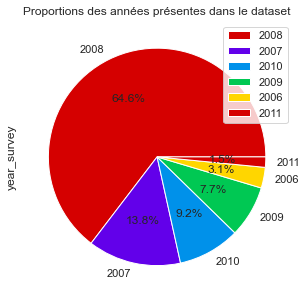

In [692]:
plt.figure(figsize=(5,5))
df['year_survey'].value_counts(normalize=True).plot(
    kind='pie',
    legend=True,
    autopct='%1.1f%%', colors=palette)
plt.title('Proportions des années présentes dans le dataset')
save_fig('survey_years')
plt.show()

## Couverture de la population

Pour connaître le pourcentage de la population mondiale couverte par l'échantillon, on récupère la population de chaque année sur Wikipedia.

In [693]:
world_pop = pd.read_html('https://en.wikipedia.org/wiki/World_population')[7]
world_pop

Year  Population Yearly growth           Density(pop/km2)  \
    Year  Population             %    Number Density(pop/km2)   
0   1951  2584034261         1.88%  47603112               17   
1   1952  2630861562         1.81%  46827301               18   
2   1953  2677608960         1.78%  46747398               18   
3   1954  2724846741         1.76%  47237781               18   
4   1955  2773019936         1.77%  48173195               19   
..   ...         ...           ...       ...              ...   
65  2016  7464022000         1.14%  84225000               50   
66  2017  7547859000         1.12%  83837000               51   
67  2018  7631091000         1.10%  83232000               51   
68  2019  7713468000         1.08%  82377000               52   
69  2020  7795000000         1.05%  81331000               52   

   Urban population       
             Number    %  
0         775067697  30%  
1         799282533  30%  
2         824289989  31%  
3         850179106  31%  
4         877008842  32%  
..              ...  ...  
65       4060653000  54%  
66       4140189000  55%  
67       4219817000  55%  
68       4299439000  56%  
69       4378900000  56%  

[70 rows x 7 columns]

In [694]:
world_pop = world_pop[['Year', 'Population']].rename(
    columns={'Year': 'year_survey', 'Population': 'population'})
world_pop['year_survey'] = world_pop['year_survey'].astype(str)
world_pop = world_pop.T.reset_index(level=[0,1])
world_pop.columns = world_pop.iloc[0]
world_pop = world_pop.iloc[1, 2:]
world_pop = pd.DataFrame([world_pop])[survey_years].T.reset_index()
world_pop.rename(columns={1: 'population', 0: 'year_survey'}, inplace=True)
world_pop

,year_survey,population
0,2006,6623518000
1,2007,6705947000
2,2008,6789089000
3,2009,6872767000
4,2010,6956824000
5,2011,7041194000


On récupère pour chaque année la fréquence d'apparition dans l'échantillon (observée précédemment sur le pie plot).

In [695]:
world_pop = pd.concat([world_pop,
    pd.DataFrame(
        df['year_survey'].value_counts(normalize=True)).reset_index().rename(
        columns={'year_survey': 'freq', 'index': 'year_survey'}).sort_values(by='year_survey')],
     axis=1)
world_pop['population_relative'] = world_pop['population'] * world_pop['freq']
world_pop

,year_survey,population,year_survey,freq,population_relative
0,2006,6623518000,2008,0.646154,4.279812e+09
1,2007,6705947000,2007,0.138462,9.285157e+08
2,2008,6789089000,2010,0.092308,6.266851e+08
3,2009,6872767000,2009,0.076923,5.286744e+08
4,2010,6956824000,2006,0.030769,2.140561e+08
5,2011,7041194000,2011,0.015385,1.083261e+08


On peut alors calculer une population mondiale moyenne adaptée à notre échantillon. 

In [696]:
pop_mondiale = world_pop['population_relative'].sum()
print('Population mondiale annuelle, entre 2006 et 2011 :', 
      round(pop_mondiale / 10**9, 1), 'milliards d\'habitants')

Population mondiale annuelle, entre 2006 et 2011 : 6.7 milliards d'habitants


In [697]:
pop_df = round(pivot['population'].sum())
print('Nombre d\'habitants estimé dans l\'échantillon :', 
      round(pop_df / 10**9, 1), 'milliards d\'habitants')

Nombre d'habitants estimé dans l'échantillon : 5.0 milliards d'habitants


Les 65 pays restants couvrent 75% de la population mondiale.

In [698]:
print('Échantillon :',
    str(round(pivot['population'].sum() / pop_mondiale * 100)) + '% de la population mondiale')

Échantillon : 75% de la population mondiale


## Diversité des distributions de revenus

On choisit un panel de 5 pays, dont la France. On verra plus tard que ces 5 pays appartiennent à 5 groupes différents en terme d'inégalités de revenus.

Ces pays disposent également de suffisamment de données pour représenter l'évolution de l'indice de Gini de 2006 à 2011.

In [699]:
pays_panel = ['France', 'Slovenia', 'Sweden', 'United States', 'Panama']
panel = df[df['Country Name'].isin(pays_panel)]
panel

,country,year_survey,quantile,income,gdpppp,gini,Country Name,population,region,IGE,income_mean
2000,FRA,2008,1,2958.3040,30357.0,0.329096,France,64374984.0,High income,0.357105,18309.407545
2001,FRA,2008,2,4412.6753,30357.0,0.329096,France,64374984.0,High income,0.357105,18309.407545
2002,FRA,2008,3,4939.6350,30357.0,0.329096,France,64374984.0,High income,0.357105,18309.407545
2003,FRA,2008,4,5422.9165,30357.0,0.329096,France,64374984.0,High income,0.357105,18309.407545
2004,FRA,2008,5,5906.5376,30357.0,0.329096,France,64374984.0,High income,0.357105,18309.407545
...,...,...,...,...,...,...,...,...,...,...,...
6195,USA,2008,96,69926.3700,43261.0,0.431799,United States,304093966.0,High income,0.537666,25503.581661
6196,USA,2008,97,77634.8200,43261.0,0.431799,United States,304093966.0,High income,0.537666,25503.581661
6197,USA,2008,98,88482.8400,43261.0,0.431799,United States,304093966.0,High income,0.537666,25503.581661
6198,USA,2008,99,106765.2600,43261.0,0.431799,United States,304093966.0,High income,0.537666,25503.581661


Le graphique suivant représente le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de
chacune des classes de revenus (axe des abscisses).

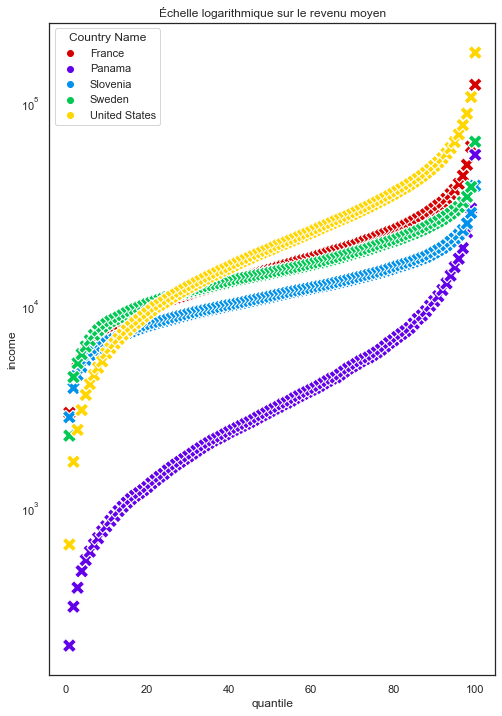

In [700]:
plt.figure(figsize=(8, 12))
ax = sns.scatterplot(
    data=panel, x='quantile', y='income', 
    hue='Country Name', marker='X', s=200, palette=palette)
ax.set(yscale="log") # échelle logarithmique sur le revenu moyen (axe des ordonnées)
plt.title('Échelle logarithmique sur le revenu moyen')
save_fig('revenu-moyen-logarithme')
plt.show()

## Courbe de Lorenz

La courbe de Lorenz permet d'observer les inégalités de revenus.

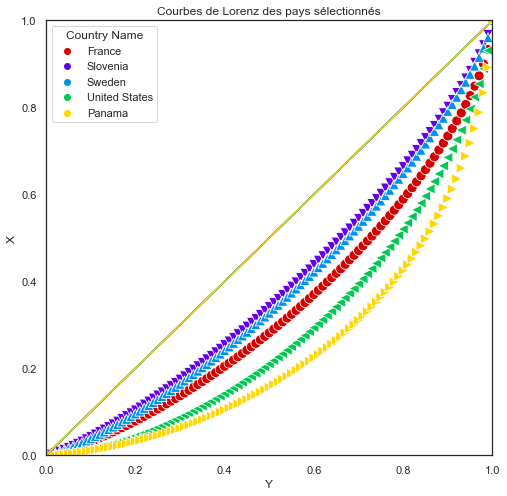

In [701]:
def lorenz(pays, couleur, marqueur):

    variable = df[df['Country Name']==pays]['income']    
    X = np.sort(variable.values)
 
    a = np.arange(0,1,.01) # Diagonale
    x = a
    y = a  
    sns.lineplot(x=x,y=y)
    
    sns.set(rc={'figure.figsize':(8,8)})
    sns.set_style('whitegrid')
    plt.xlim([0,1])
    plt.ylim([0,1])

    X_lorenz = X.cumsum() / X.sum() # Courbe de Lorenz
    X_lorenz = np.insert(X_lorenz, 0, 0)
    # X_lorenz[0], X_lorenz[-1]
    y = np.arange(X_lorenz.size)/(X_lorenz.size-1)
    lorenz = pd.DataFrame()
    lorenz['X'] = pd.Series(X_lorenz)
    lorenz['Y'] = pd.Series(y)
    lorenz['Country Name'] = pays
    sns.scatterplot(data=lorenz, x='Y', y='X', hue='Country Name', 
                    marker=marqueur, palette=[couleur], s=100)

plt.figure(figsize=(8, 8))
markers = ['o', 'v', '^', '<', '>']

for i in range(0, len(pays_panel)):
    lorenz(pays_panel[i], palette[i], markers[i])
    
plt.title('Courbes de Lorenz des pays sélectionnés')
save_fig('lorenz')

## Évolution de l'indice de Gini

D'autres années pour l'indice de Gini sont disponibles sur le site de la [Banque mondiale](https://databank.worldbank.org/source/world-development-indicators/Type/TABLE/preview/on#). On récupère pour chaque pays du panel les indices de Gini de 2006 à 2011.

In [702]:
ginis = pd.read_csv(sources + 'API_SI.POV.GINI_DS2_en_csv_v2_2441674.csv', skiprows=4)
ginis

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN,NaN
3,Albania,ALB,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,29.0,NaN,34.6,32.9,33.7,33.2,NaN,NaN,NaN,NaN
4,Andorra,AND,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,29.0,26.3,27.3,26.5,26.7,29.0,NaN,NaN,NaN,NaN
260,"Yemen, Rep.",YEM,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,36.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,South Africa,ZAF,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,Zambia,ZMB,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,57.1,NaN,NaN,NaN,NaN,NaN,NaN


In [703]:
ginis = ginis[vars_projection + survey_years]
ginis = ginis[ginis['Country Name'].isin(pivot['Country Name'])]
ginis = ginis.dropna().sort_values(by=max(survey_years))
ginis

,Country Code,Country Name,2006,2007,2008,2009,2010,2011
220,SVN,Slovenia,24.4,24.4,23.7,24.8,24.9,24.9
175,NOR,Norway,26.4,27.1,27.0,26.2,25.7,25.3
52,CZE,Czech Republic,26.7,26.0,26.3,26.2,26.6,26.4
219,SVK,Slovak Republic,25.8,24.7,26.0,27.2,27.3,26.5
23,BLR,Belarus,28.3,29.6,27.8,27.7,28.6,27.2
56,DNK,Denmark,25.9,26.2,25.2,26.7,27.2,27.3
73,FIN,Finland,28.0,28.3,27.8,27.5,27.7,27.6
221,SWE,Sweden,26.4,27.1,28.1,27.3,27.7,27.6
120,KGZ,Kyrgyz Republic,37.4,33.9,31.5,29.9,30.1,27.8
174,NLD,Netherlands,30.0,29.6,29.3,27.9,27.8,27.8


In [704]:
ginis = ginis.set_index(
    ['Country Code', 'Country Name']
    ).stack().reset_index().rename(
    columns={'level_2': 'year_survey', 0: 'gini'})
ginis

,Country Code,Country Name,year_survey,gini
0,SVN,Slovenia,2006,24.4
1,SVN,Slovenia,2007,24.4
2,SVN,Slovenia,2008,23.7
3,SVN,Slovenia,2009,24.8
4,SVN,Slovenia,2010,24.9
...,...,...,...,...
175,PAN,Panama,2007,52.7
176,PAN,Panama,2008,52.7
177,PAN,Panama,2009,51.8
178,PAN,Panama,2010,51.6


In [705]:
ginis_panel = ginis[ginis['Country Name'].isin(pays_panel)]
ginis_panel

,Country Code,Country Name,year_survey,gini
0,SVN,Slovenia,2006,24.4
1,SVN,Slovenia,2007,24.4
2,SVN,Slovenia,2008,23.7
3,SVN,Slovenia,2009,24.8
4,SVN,Slovenia,2010,24.9
5,SVN,Slovenia,2011,24.9
42,SWE,Sweden,2006,26.4
43,SWE,Sweden,2007,27.1
44,SWE,Sweden,2008,28.1
45,SWE,Sweden,2009,27.3


L'inégalité d'un pays se mesure par la force de son indice de Gini. On peut représenter l'évolution de cette inégalité sur la durée de l'étude. Elle a notamment progressé en France.

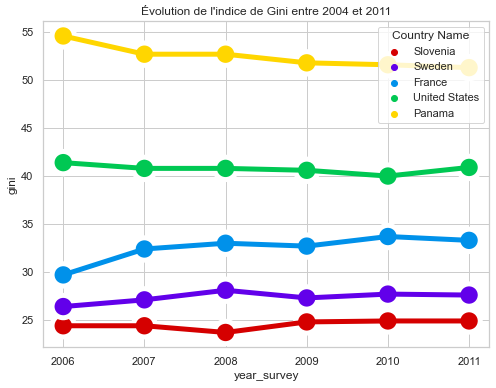

In [706]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=ginis_panel, x='year_survey', y='gini', hue='Country Name', linewidth=5, legend=False, palette=palette)
sns.scatterplot(data=ginis_panel, x='year_survey', y='gini', hue='Country Name', linewidth=5, s=500, palette=palette)
plt.title('Évolution de l\'indice de Gini entre 2004 et 2011')
save_fig('evolution_gini')
plt.show()

## Classements par indice de Gini

In [707]:
classement_gini = pivot[['Country Name', 'gini']].sort_values(by='gini').reset_index().drop(['index'], axis=1)
classement_gini

,Country Name,gini
0,Slovenia,0.230731
1,Slovak Republic,0.247219
2,Czech Republic,0.252864
3,Sweden,0.254887
4,Denmark,0.259871
...,...,...
60,Brazil,0.544494
61,Bolivia,0.561476
62,Guatemala,0.568293
63,Colombia,0.569271


In [708]:
print('Moyenne des indices de Gini :',
      round(classement_gini['gini'].mean()*100), '%')

Moyenne des indices de Gini : 37 %


Les 5 pays les plus égalitaires (indice de Gini le plus faible).

In [709]:
classement_gini.head(5)

,Country Name,gini
0,Slovenia,0.230731
1,Slovak Republic,0.247219
2,Czech Republic,0.252864
3,Sweden,0.254887
4,Denmark,0.259871


Les 5 pays les plus inégalitaires (indice de Gini le plus fort).

In [710]:
classement_gini.sort_values(by='gini', ascending=False).head(5)

,Country Name,gini
64,South Africa,0.669779
63,Colombia,0.569271
62,Guatemala,0.568293
61,Bolivia,0.561476
60,Brazil,0.544494


La France occupe une place moyenne dans le classement.

In [711]:
position_france = classement_gini[classement_gini['Country Name']=='France']
print('France :\n', 
        position_france.index[0], 'ème pays le plus égalitaire\n',
        len(classement_gini) + 1 - position_france.index[0], 
        'ème pays le plus inégalitaire\nIndice de Gini :',
        round(float(position_france['gini']), 2), '\n')

France :
 26 ème pays le plus égalitaire
 40 ème pays le plus inégalitaire
Indice de Gini : 0.33 



# Génération de la classe parent

## Génération de réalisations d'une variable

On génére un grand nombre de réalisations d'une variable qu'on appelera
selon une loi normale. Le choix de la moyenne et de l'écart-type n'ont pas d'incidence sur le résultat final (sur le calcul de la classe de revenus). 

*n* doit être supérieur à 1000 fois le nombre de quantiles.

In [712]:
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = 1000 * nb_quantiles # taille de l'échantillon

*lny_parents* : on génère les revenus des parents (exprimés en logs) selon une loi normale.

In [713]:
ln_y_parent = st.norm(0,1).rvs(size=n)
print(ln_y_parent)

[-0.14469876 -0.17770411  0.20999969 ... -1.49323234 -1.81220464
 -0.66692219]


100000 observations :

 [-0.14469876 -0.17770411  0.20999969 ... -1.49323234 -1.81220464
 -0.66692219]


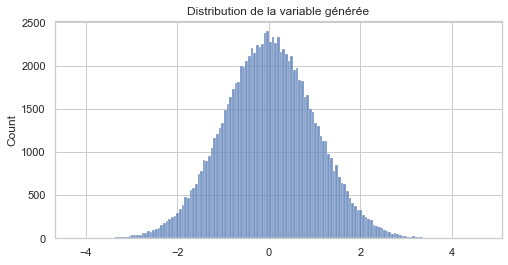

In [714]:
def visu_realisations(data):
    print(len(data), 'observations :\n\n', data)
    plt.figure(figsize=(8, 4))
    sns.histplot(data)
    plt.title('Distribution de la variable générée')
    plt.show()
    
visu_realisations(ln_y_parent)

## Génération de réalisations du terme d'erreur

On génère maintenant les résidus (le terme d'erreur epsilon) selon une loi normale de moyenne 0 et d'écart-type 1.

100000 observations :

 [ 0.72056492  0.84329221 -0.63013123 ...  0.38683096  0.48690955
 -0.07442799]


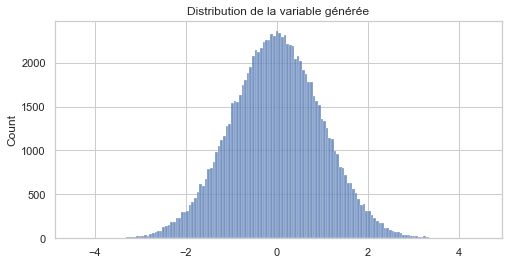

In [715]:
residus = st.norm(0,1).rvs(size=n)
visu_realisations(residus)

## Calcul de *y_child*

Pour une valeur donnée de *pj* (par exemple 0.9), on calcule *ychild*. Le choix de *a* n'a aucune incidence sur le résultat final et peut être supprimé. A ce stade, ychild contient des valeurs dont l'ordre de grandeur ne reflète pas la réalité, mais cela n'a pas d'influence pour la suite.

In [716]:
def generate_incomes(n, pj):   # formulae à récupérer
    return np.exp(pj * ln_y_parent + residus), np.exp(ln_y_parent)

pj = 0.7 # coefficient d'élasticité du pays j
y_child, y_parents = generate_incomes(n, pj)

100000 observations :

 [1.85758227 2.0521732  0.61684873 ... 0.51766256 0.45765773 0.58200658]


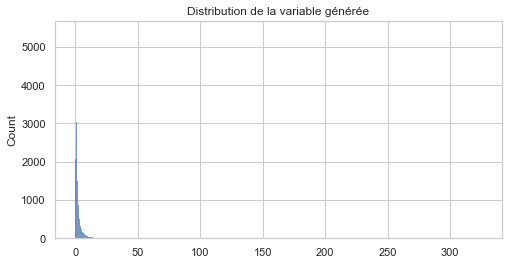

In [717]:
visu_realisations(y_child)

100000 observations :

 [0.86528291 0.8371901  1.23367767 ... 0.22464535 0.16329374 0.51328595]


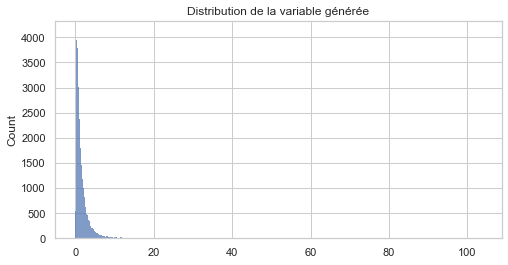

In [718]:
visu_realisations(y_parents)

## Calcul de la classe de revenus des enfants

Pour chacun des individus générés, on calcule maintenant la classe de revenu *c_i_child* ainsi que la classe de revenu de ses parents , à partir de *ychild* et *yparent*.

In [719]:
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

sample = compute_quantiles(y_child, y_parents, nb_quantiles)
sample

,y_child,y_parents,c_i_child,c_i_parent
0,1.857582,0.865283,70,45
1,2.052173,0.837190,73,43
2,0.616849,1.233678,35,59
3,15.273448,7.242267,99,98
4,5.313596,1.306459,92,61
...,...,...,...,...
99995,1.254662,3.297281,58,89
99996,0.036814,0.055489,1,1
99997,0.517663,0.224645,30,7
99998,0.457658,0.163294,27,4


## Distribution conditionnelle de *c_i_parent*

A partir de cette dernière information, on estime pour chaque *c_i_child* la distribution
conditionnelle de *c_i_parent*. 

Par exemple, si on observe 6 individus ayant à la fois cichild=5 et ciparent=8
, et que 200 individus sur 20000 ont cichild=5, alors la probabilité d'avoir ciparent=8
sachant cichild=5 et sachant pj=0.9 sera estimée à 6/200 (On note cette
probabilité comme ceci : ). Si la population est divisée en c classes de revenu, on devrait alors avoir c2 estimations de ces probabilités
conditionnelles, pour chaque pays.

In [720]:
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib  

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

cd = conditional_distributions(sample, nb_quantiles)
cd

array([[0.193, 0.1  , 0.051, ..., 0.   , 0.   , 0.   ],
       [0.105, 0.077, 0.04 , ..., 0.   , 0.   , 0.   ],
       [0.056, 0.062, 0.047, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.06 , 0.054, 0.06 ],
       [0.   , 0.   , 0.   , ..., 0.06 , 0.071, 0.097],
       [0.   , 0.   , 0.   , ..., 0.069, 0.094, 0.177]])

## Représentations des distributions conditionnelles

Pour vérifier la cohérence du code, on crée un graphique
représentant ces distributions conditionnelles. Voici 2 exemples pour une population
segmentée en 10 classes, d'abord avec une forte mobilité (0.1) :

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


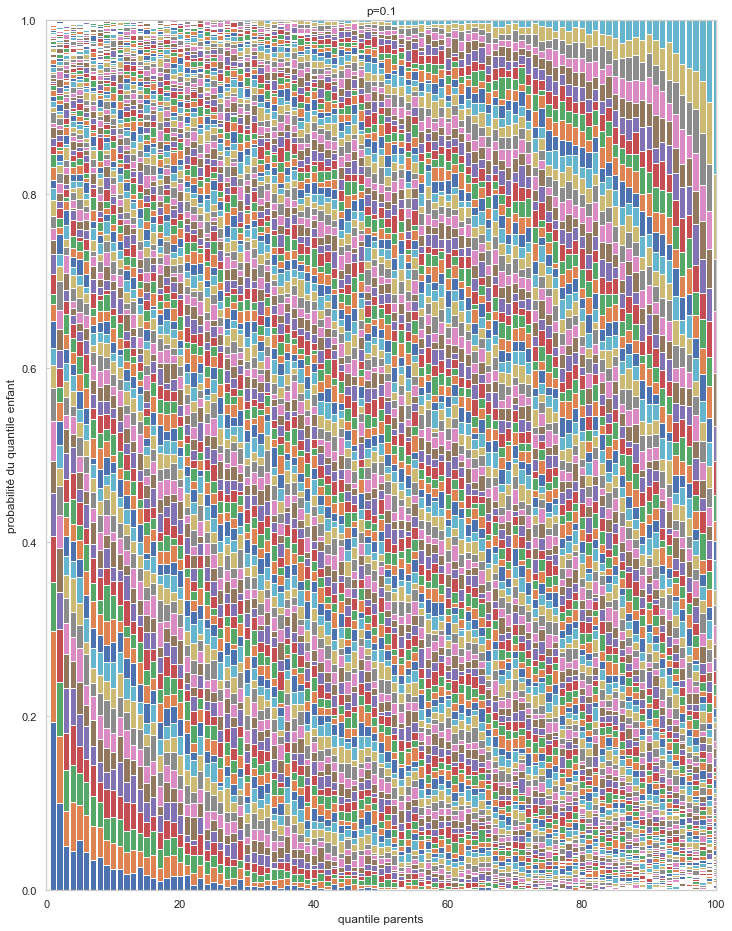

In [721]:
def plot_conditional_distributions(p, cd, nb_quantiles):
    
    plt.figure(figsize=(12,16))
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.legend([],[], frameon=False)
    plt.xlim([0,100])
    plt.show()

plot_conditional_distributions(0.1, cd, nb_quantiles)

Et avec une très faible mobilité (0.9) :

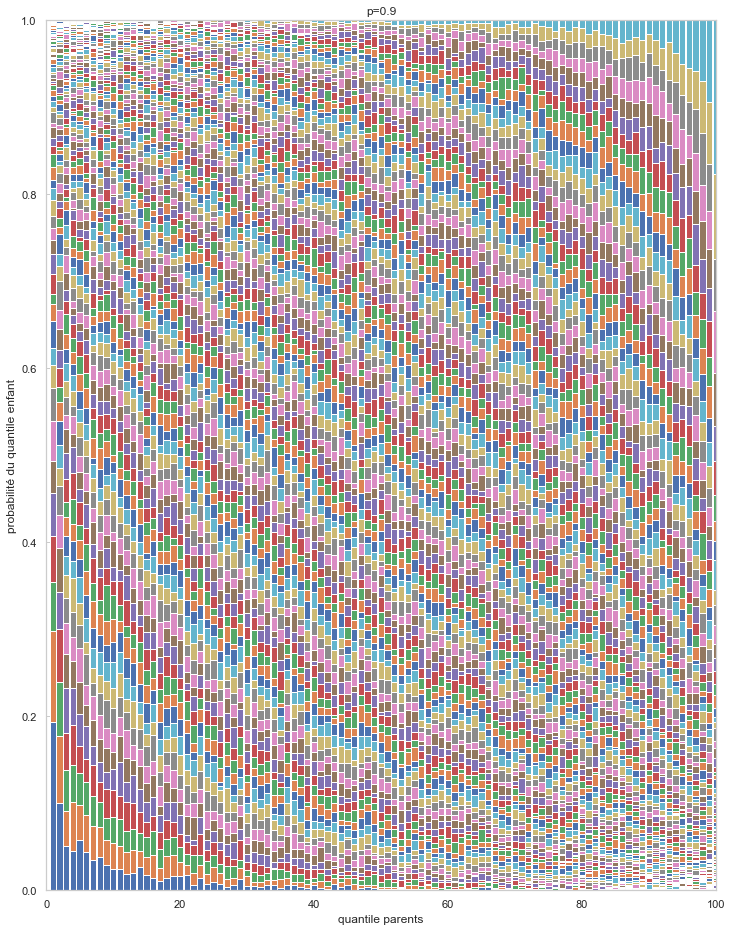

In [722]:
plot_conditional_distributions(0.9, cd, nb_quantiles)

## Nouvel échantillon

On va maintenant travailler sur un nouvel échantillon. Celui-ci sera créé à partir des données principales. Pour chaque individu dans le dataset, on en crée 499 "clones". La taille du nouvel échantillon sera donc 500 fois plus grand que celui d'origine.

On obtient plus de 3 millions d'individus.

In [723]:
sample = pd.concat([df]*500).reset_index().drop('index', axis=1)
sample

,country,year_survey,quantile,income,gdpppp,gini,Country Name,population,region,IGE,income_mean
0,ALB,2008,1,728.89795,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902
1,ALB,2008,2,916.66235,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902
2,ALB,2008,3,1010.91600,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902
3,ALB,2008,4,1086.90780,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902
4,ALB,2008,5,1132.69970,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902
...,...,...,...,...,...,...,...,...,...,...,...
3249995,COD,2008,96,810.62330,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044
3249996,COD,2008,97,911.78340,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044
3249997,COD,2008,98,1057.80740,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044
3249998,COD,2008,99,1286.60290,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044


## Attribution des classes des parents

Pour chaque c_i_child et chaque pays, il y a maintenant 500 individus. On attribue aux 500
individus leurs classes c_i_parent conformément aux distributions trouvées précédemment. Par exemple, si P(ci,parent = 8|ci,child = 5, pj = 0.9) = 0.03, alors vous assignerez la classe ciparent=8
à 15 des 500 individus du pays ayant cichild=5, car 500*0.03 = 15.

In [724]:
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = len(sample) # taille de l'échantillon
ln_y_parent = st.norm(0,1).rvs(size=n)
residus = st.norm(0,1).rvs(size=n)

In [725]:
sample = pd.concat([
    pd.DataFrame(list(zip(ln_y_parent, residus)), columns=['ln_y_parent','residus']), 
    sample], axis=1)
sample

,ln_y_parent,residus,country,year_survey,quantile,income,gdpppp,gini,Country Name,population,region,IGE,income_mean
0,1.249733,1.535560,ALB,2008,1,728.89795,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902
1,0.695193,0.101968,ALB,2008,2,916.66235,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902
2,0.367120,0.267086,ALB,2008,3,1010.91600,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902
3,0.950536,-0.440352,ALB,2008,4,1086.90780,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902
4,-0.413426,1.749442,ALB,2008,5,1132.69970,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249995,-0.178941,-0.158574,COD,2008,96,810.62330,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044
3249996,0.051849,2.347617,COD,2008,97,911.78340,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044
3249997,0.341739,0.195381,COD,2008,98,1057.80740,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044
3249998,0.697905,0.011431,COD,2008,99,1286.60290,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044


In [726]:
sample

,ln_y_parent,residus,country,year_survey,quantile,income,gdpppp,gini,Country Name,population,region,IGE,income_mean
0,1.249733,1.535560,ALB,2008,1,728.89795,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902
1,0.695193,0.101968,ALB,2008,2,916.66235,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902
2,0.367120,0.267086,ALB,2008,3,1010.91600,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902
3,0.950536,-0.440352,ALB,2008,4,1086.90780,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902
4,-0.413426,1.749442,ALB,2008,5,1132.69970,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249995,-0.178941,-0.158574,COD,2008,96,810.62330,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044
3249996,0.051849,2.347617,COD,2008,97,911.78340,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044
3249997,0.341739,0.195381,COD,2008,98,1057.80740,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044
3249998,0.697905,0.011431,COD,2008,99,1286.60290,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044


In [727]:
def generate_y_child(n, pj):
    return np.exp(pj * ln_y_parent + residus)

def generate_y_parents(n, pj):
    return np.exp(ln_y_parent)

sample['y_child'] = 0
sample['y_child'] = generate_y_child(n, sample['IGE'])
sample['y_parents'] = 0
sample['y_parents'] = generate_y_parents(n, sample['IGE'])
sample

,ln_y_parent,residus,country,year_survey,quantile,income,gdpppp,gini,Country Name,population,region,IGE,income_mean,y_child,y_parents
0,1.249733,1.535560,ALB,2008,1,728.89795,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902,12.873686,3.489411
1,0.695193,0.101968,ALB,2008,2,916.66235,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902,1.952593,2.004095
2,0.367120,0.267086,ALB,2008,3,1010.91600,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902,1.762282,1.443572
3,0.950536,-0.440352,ALB,2008,4,1086.90780,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902,1.398173,2.587095
4,-0.413426,1.749442,ALB,2008,5,1132.69970,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902,4.104722,0.661380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249995,-0.178941,-0.158574,COD,2008,96,810.62330,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044,0.751855,0.836155
3249996,0.051849,2.347617,COD,2008,97,911.78340,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044,10.851580,1.053216
3249997,0.341739,0.195381,COD,2008,98,1057.80740,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044,1.548413,1.407393
3249998,0.697905,0.011431,COD,2008,99,1286.60290,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044,1.657550,2.009538


On classe les c_i_child et c_i_parent par centile.

In [728]:
sample['c_i_child'] = pd.qcut(sample['y_child'], 100, labels=False) + 1
sample['c_i_parent'] = pd.qcut(sample['y_parents'], 100, labels=False) + 1
sample

,ln_y_parent,residus,country,year_survey,quantile,income,gdpppp,gini,Country Name,population,region,IGE,income_mean,y_child,y_parents,c_i_child,c_i_parent
0,1.249733,1.535560,ALB,2008,1,728.89795,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902,12.873686,3.489411,99,90
1,0.695193,0.101968,ALB,2008,2,916.66235,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902,1.952593,2.004095,73,76
2,0.367120,0.267086,ALB,2008,3,1010.91600,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902,1.762282,1.443572,70,65
3,0.950536,-0.440352,ALB,2008,4,1086.90780,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902,1.398173,2.587095,62,83
4,-0.413426,1.749442,ALB,2008,5,1132.69970,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902,4.104722,0.661380,90,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249995,-0.178941,-0.158574,COD,2008,96,810.62330,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044,0.751855,0.836155,41,43
3249996,0.051849,2.347617,COD,2008,97,911.78340,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044,10.851580,1.053216,98,53
3249997,0.341739,0.195381,COD,2008,98,1057.80740,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044,1.548413,1.407393,65,64
3249998,0.697905,0.011431,COD,2008,99,1286.60290,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044,1.657550,2.009538,68,76


In [729]:
len(sorted(sample['c_i_child'].unique()))

100

Pour éviter toute confusion, on efface la variable c_i_child, inutile pour la suite.

In [730]:
sample.drop(['c_i_child', 'y_child', 'y_parents','ln_y_parent','residus'], axis=1, inplace=True)
sample

,country,year_survey,quantile,income,gdpppp,gini,Country Name,population,region,IGE,income_mean,c_i_parent
0,ALB,2008,1,728.89795,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902,90
1,ALB,2008,2,916.66235,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902,76
2,ALB,2008,3,1010.91600,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902,65
3,ALB,2008,4,1086.90780,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902,83
4,ALB,2008,5,1132.69970,7297.00000,0.304624,Albania,2947314.0,Europe & Central Asia,0.815874,2994.829902,34
...,...,...,...,...,...,...,...,...,...,...,...,...
3249995,COD,2008,96,810.62330,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044,43
3249996,COD,2008,97,911.78340,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044,53
3249997,COD,2008,98,1057.80740,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044,64
3249998,COD,2008,99,1286.60290,303.19305,0.443997,"Congo, Dem. Rep.",60411195.0,Sub-Saharan Africa,0.707703,276.016044,76


# Modélisation

On va maintenant chercher à expliquer le revenu des individus en fonction de plusieurs
variables explicatives
On va chercher à prédire le revenu des enfants (*income*) en prenant comme explicatives les autres variables à disposition : le pays de l'individu, l'indice de Gini de ce pays, la classe de revenus des
parents, etc.

On dispose de plusieurs variables quantitatives et d'une seule qualitative : le pays (on exclue la région). On testera au préalable si le pays a un impact sur le revenu enfant, avec une ANOVA. 

La régression linéaire prendra les variables quantitatives de notre choix comme prédicteurs du revenu enfant.


## ANOVA

L'ANOVA compare les moyennes entre plus de 2 groupes (ici, les pays). On cherchera à rejeter l'hypothèse 0, selon laquelle les moyennes (ici, de revenus enfants) ne varient pas entre pays. 

Si les moyennes de revenu diffèrent entre les groupes, on pourra dire que le pays est corrélé au revenu des enfants. 

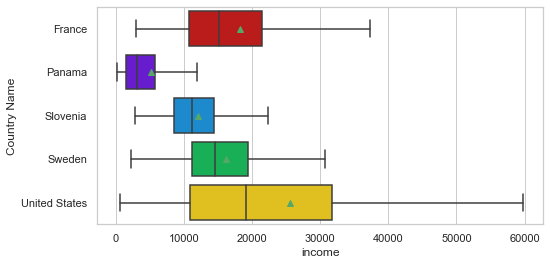

In [731]:
plt.figure(figsize=(8,4))
sns.boxplot(
    data=sample[sample['Country Name'].isin(pays_panel)], 
    x='income', y='Country Name', palette=palette, 
    showfliers=False, showmeans=True)
save_fig('boxplot_panel_income')
plt.show()

In [732]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

In [733]:
lm = ols('income ~ country', data=sample).fit()

La p-value inférieure à 5% permet d'accepter l'hypothèse 1 : une ou plusieurs des moyennes de revenus sont différentes entre pays.

Le pays et le revenu des enfants seraient donc corrélés, mais on doit vérifier certaines conditions avant de valider l'ANOVA :
1. La normalité des résidus
2. L'homoscédasticité des résidus (homogénéité des variances)

In [734]:
def test_anova(lm):
    anova_table = sm.stats.anova_lm(lm, typ=2)
    p = anova_table['PR(>F)'][0]
    print('ANOVA\n', anova_table)
    print(
        '\np-value :', p, 
        '\nstat (F) :', anova_table['F'][0])
    if p > 0.05:
        print('H0: the means of the samples are equal')
    else:
        print('H1: one or more of the means of the samples are unequal')
    
test_anova(lm)

ANOVA
                 sum_sq         df             F  PR(>F)
country   1.811892e+14       64.0  44703.378273     0.0
Residual  2.058196e+14  3249935.0           NaN     NaN

p-value : 0.0 
stat (F) : 44703.378273475944
H1: one or more of the means of the samples are unequal


Le test de Shapiro renvoie une p-value de 0% : la distribution des résidus n'est probablement pas normale.

Test de Shapiro :

stats : 0.6095524430274963 
p-value : 0.0
H0 rejetée : distribution probablement pas normale


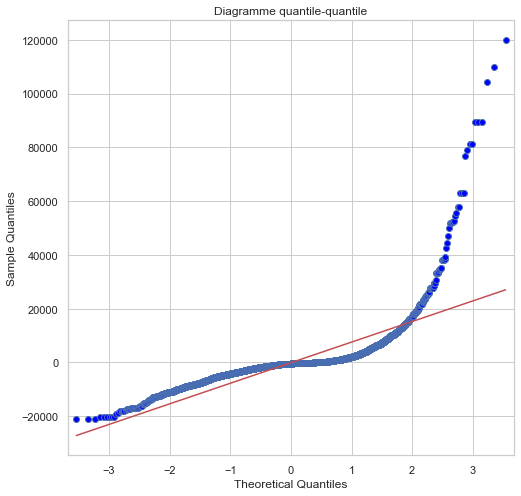

In [735]:
def test_shapiro(data):
    shapiro_table = stats.shapiro(data)
    p = shapiro_table[1]
    print('Test de Shapiro :')
    print('\nstats :', shapiro_table[0],
        '\np-value :', p)
    if p>.05:
        print('H0 acceptée : distribution normale')
    else:
        print('H0 rejetée : distribution probablement pas normale')

    qqplot(data, line='s')
    plt.title('Diagramme quantile-quantile')
    plt.show()
    
test_shapiro(lm.resid.sample(5000))

L'homogénéité des résidus peut être mesurée avec le test de Levene. On obtient une p-value inférieure à 5 %, validant l'hypothèse 1 : les variances des groupes sont différentes, il n'y a donc pas d'homoscédasticité, requise par l'ANOVA.

In [736]:
import pingouin as pg

In [737]:
pg.homoscedasticity(sample, dv='income', group='Country Name')

,W,pval,equal_var
levene,11760.920273,0.0,False


Comme alternative à l'ANOVA, on peut utiliser le test non paramétrique de Kruskal-Wallis quand ni la normalité ni l'homoscédasticité ne peuvent être vérifiées. 

La p-value est encore inférieure à 5%, et valide l'ANOVA précédente : les revenus moyens diffèrent bien entre pays.

In [738]:
pg.kruskal(sample, dv='income', between='Country Name')

,Source,ddof1,H,p-unc
Kruskal,Country Name,64,2.539578e+06,0.0


## Variables au logarithme

Pour chacune des régressions suivantes, on testera 2 versions : l'une en exprimant le revenu moyen du pays et les revenus (parents & enfants) en logarithme (ln), l'autre en les laissant tels quels. On choisira la version la plus performante.

On passe d'abord certaines variables au logarithme (inverse de l'exponentielle) pour en créer de nouvelles. Les valeurs sont centrées et réduites. On ne convertit pas *gini* et *IGE*, dont les variables sont déjà à échelle.

In [739]:
sample['income_ln'] = np.log(sample['income'])
sample['income_mean_ln'] = np.log(sample['income_mean'])
sample['population_ln'] = np.log(sample['population'])
sample['gdpppp_ln'] = np.log(sample['gdpppp'])
sample.sample()

,country,year_survey,quantile,income,gdpppp,gini,Country Name,population,region,IGE,income_mean,c_i_parent,income_ln,income_mean_ln,population_ln,gdpppp_ln
1818953,RUS,2008,54,5405.847,14766.0,0.416691,Russian Federation,142742366.0,Europe & Central Asia,0.33,7156.770709,80,8.595236,8.875814,18.776552,9.600083


Projetées sur un nuage de points, les variables montrent des droites de régression plus ou moins marquées : le revenu moyen et le PPA semblent avoir des relations plus linéaires avec le revenu des individus. On peut potentiellement mieux prédire les données avec ces variables.

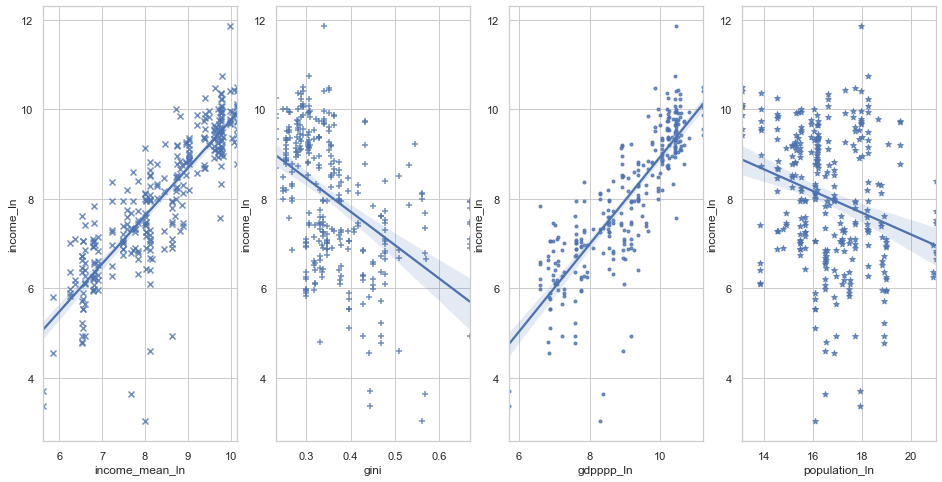

In [740]:
sample_regplots = sample.sample(300)
fig, ax = plt.subplots(1, 4, figsize=(16,8))
sns.regplot(data=sample_regplots, x='income_mean_ln', y='income_ln', marker='x', ax=ax[0])
sns.regplot(data=sample_regplots, x='gini', y='income_ln', marker='+', ax=ax[1])
sns.regplot(data=sample_regplots, x='gdpppp_ln', y='income_ln', marker='.', ax=ax[2])
sns.regplot(data=sample_regplots, x='population_ln', y='income_ln', marker='*', ax=ax[3])
save_fig('regressions')
plt.show()

## Revenu moyen + Gini

On n'inclut d'abord dans la régression que 2 variables explicatives : le revenu moyen du pays de l’individu, et son indice de Gini.


### Avec logarithme

On teste un premier modèle avec les variables passées au logarithme. On verra que des variables à la même échelle renforcent la performance du modèle. Le résumé fournit plusieurs indicateurs clés :

**R-squared** (R2) mesure la qualité de prédiction d'une régression linéaire :

- c'est la variance des résidus
- on peut la nommer variance expliquée, décomposition de variance totale ou coefficient de détermination
- elle doit idéalement s'approcher de 1

Dans le deuxième tableau, on trouve le coefficient de régression (**coef**) de la variable concernée :
- la valeur prédite sera égale la somme de tous les valeurs explicatives, multipliées par leurs coefficients de variable respectifs
- l'objectif de la régression sera de trouver la combinaison de coefficients expliquant le maximum de variance

**P>[t]** indique la significativité de ce coefficient :
- plus cette p-value sera élevée, moins la variable sera intéressante
- elle mesure la significativité des coefficients de variables (colonne *coef*)

**Cond. No.** mesure la colinéarité des variables :
- plus sa valeur est grande, plus il y a de colinéarité
- la multicolinéarité affecte la peformance d'un modèle : on cherchera la valeur la plus basse possible
- le VIF (variance inflation factor) est un outil plus précis pour mesurer la multicolinéarité


Ici, avec les variables au logarithme on constate que :
- le modèle explique 76% de la variance
- les 2 variables contribuent toutes deux aux modèle, avec un P>|t| à 0
- le coefficient de significativité du revenu moyen est positif, tandis que celui du Gini est négatif. Plus l'indice de Gini sera haut (signe d'inégalité), plus le revenu prédit sera faible. 

In [741]:
model_mini_ln = smf.ols(formula='income_ln ~ income_mean_ln + gini', data=sample).fit()
print(model_mini_ln.summary())

                            OLS Regression Results                            
Dep. Variable:              income_ln   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                 5.344e+06
Date:                Fri, 09 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:37:11   Log-Likelihood:            -3.5146e+06
No. Observations:             3250000   AIC:                         7.029e+06
Df Residuals:                 3249997   BIC:                         7.029e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4774      0.004    132.

La matrice des corrélations confirme une corrélation modérée et négative entre les deux explicatives (plus l'indice de Gini est bas, plus le revenu moyen a tendance à être haut).

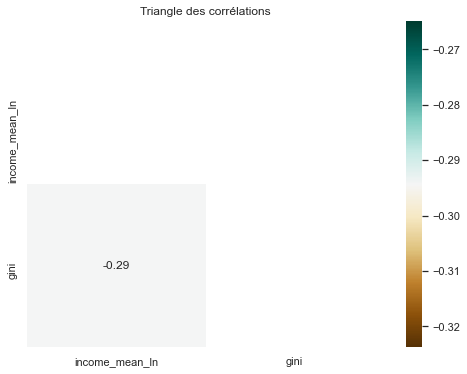

In [742]:
correlation_matrix = sample[['income_mean_ln', 'gini']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='BrBG')
plt.title('Triangle des corrélations')
save_fig('triangle-correlations')
plt.show()

Pour accepter une régression linéaire, on veut que ses rédidus soient distribués normalement. Les résidus du QQ plot montre qu'elle s'en approche, mais les outliers empêchent de qualifier la distribution de normale.

Test de Shapiro :

stats : 0.9654936790466309 
p-value : 5.448745454479533e-33
H0 rejetée : distribution probablement pas normale


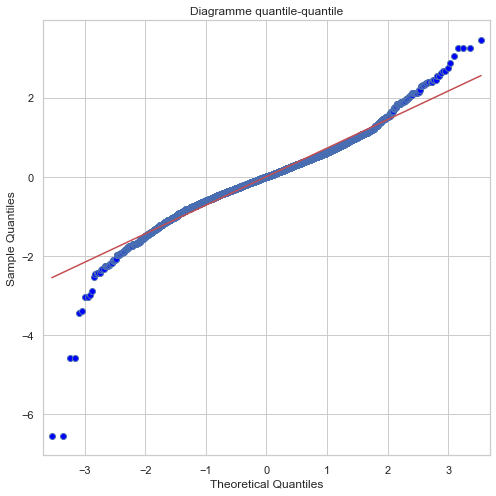

In [743]:
residus = model_mini_ln.resid.sample(5000)
test_shapiro(residus)

Les données avec d'importants résidus (données aberrantes) [et/ou fort effet de levier](https://fr.wikipedia.org/wiki/Distance_de_Cook) peuvent fausser le résultat et la précision d'une régression. Le z-score permet de normaliser la position des outliers. 

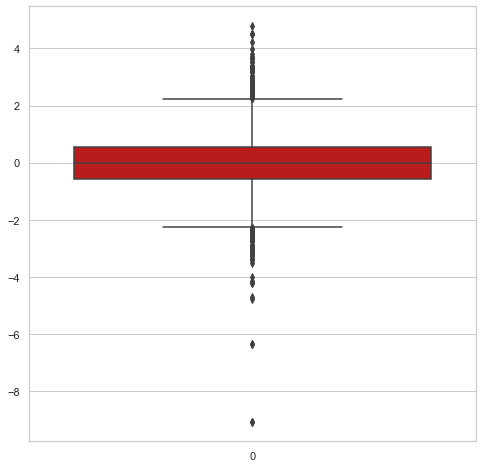

In [744]:
residus_zscore = pd.Series(stats.zscore(residus))
sns.boxplot(data=residus_zscore, palette=palette)
save_fig('residus_z_score')
plt.show()

On peut alors ne sélectionner que les résidus ayant un z-score au-dessous d'un certain seuil.

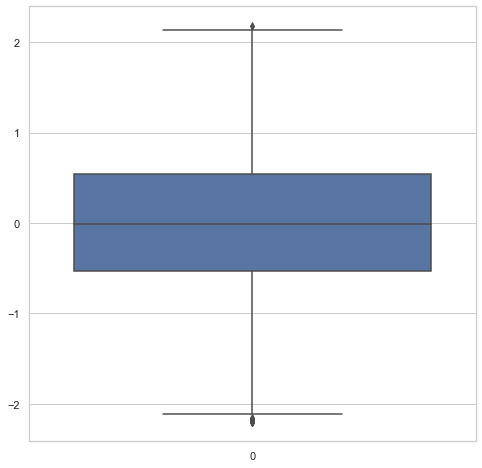

In [745]:
residus_zscore = residus_zscore[abs(residus_zscore) < 2.2].dropna()
sns.boxplot(data=residus_zscore)
save_fig('residus_zscore_cut')
plt.show()

La p-value du test de Shapiro ne suffit pas à rejeter l'hypothèse, mais le QQ plot montre des résidus toujours plus proches de la normale.

Test de Shapiro :

stats : 0.9979646801948547 
p-value : 5.9316903389117215e-06
H0 rejetée : distribution probablement pas normale


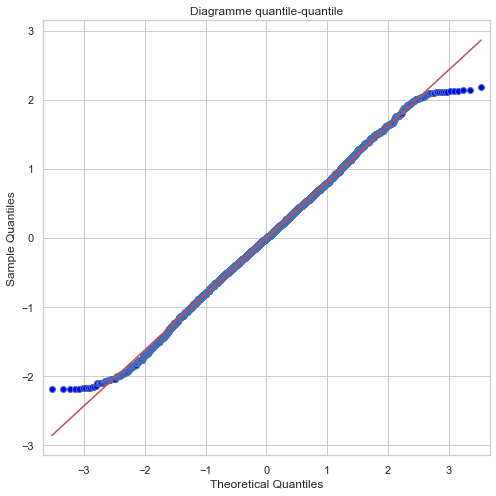

In [746]:
test_shapiro(residus_zscore)

### Sans logarithme

En passant des 2 variables dans le modèle, on obtient une variance des résidus (*R-squared*) plus faible. L'échelle des valeurs de *income_mean* a trop poids face à celles de *gini* : 
- la variance des résidus est beaucoup moins élévée qu'avec le modèle précédent
- la variable *gini* n'est plus significative (p-value de 1)  
- *income_mean* explique à elle seule le modèle (p-value de 0) 
- la colinéarité est beaucoup plus forte que précédemment (le modèle renvoie d'ailleurs un avertissement cette fois-ci)
- le coefficient de la seule variable significative (*income_mean*) passe à 1 : pas besoin de multiplier sa valeur vu qu'elle est la seule avec l'intercept dans la formule de régression.

In [747]:
model_mini = smf.ols(formula='income ~ income_mean + gini', data=sample).fit()
print(model_mini.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                 1.431e+06
Date:                Fri, 09 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:37:15   Log-Likelihood:            -3.3803e+07
No. Observations:             3250000   AIC:                         6.761e+07
Df Residuals:                 3249997   BIC:                         6.761e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.846e-10     21.518  -1.32e-11      

La distribution des résidus s'éloigne beaucoup plus de la normale qu'avec le modèle précédent. La régression linéaire a besoin d'une distribution normale des résidus, les données passées au logarithme sont donc là encore plus pertinentes.

Test de Shapiro :

stats : 0.5883033275604248 
p-value : 0.0
H0 rejetée : distribution probablement pas normale


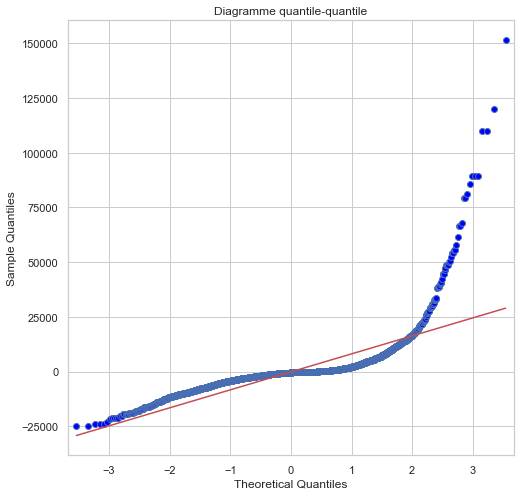

In [748]:
residus = model_mini.resid.sample(5000)
test_shapiro(residus)

## Ajout de la classe parents

### Avec logarithme

En ajoutant juste la classe parents, on obtient une variance expliquée égale à celle obtenue plus tôt sans cette variable. *Income_mean_ln* et *gini_ln* sont toujours aussi significatives, mais la classe parents obtient une P>|t| de 95%, indiquant une probable absence de significativé de cette variable.

Le modèle explique la même variance que sans la classe parent, mais la colinéarité est plus forte : mieux vaut donc ne pas choisir cette variable comme explicative pour renforcer la robustesse du modèle.

In [749]:
model_ln = smf.ols(formula='income_ln ~ income_mean_ln + gini + c_i_parent', data=sample).fit()
print(model_ln.summary())

                            OLS Regression Results                            
Dep. Variable:              income_ln   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                 3.562e+06
Date:                Fri, 09 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:37:17   Log-Likelihood:            -3.5146e+06
No. Observations:             3250000   AIC:                         7.029e+06
Df Residuals:                 3249996   BIC:                         7.029e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4783      0.004    130.

### Sans logarithme

Sans logarithme, la variance expliquée est la même que précédemment, qu'on ajoute *c_i_parent* ou non. L'indice de Gini garde la même absence de significativité, comme *c_i_parent*. Le revenu moyen reste la seule variable significative.

In [750]:
model = smf.ols(formula='income ~ income_mean + gini + c_i_parent', data=sample).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                 9.537e+05
Date:                Fri, 09 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:37:19   Log-Likelihood:            -3.3803e+07
No. Observations:             3250000   AIC:                         6.761e+07
Df Residuals:                 3249996   BIC:                         6.761e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       8.5413     22.871      0.373      

## Optimisation

On a vu que passer les variables au logarithme renforce la robustesse du modèle, et que les variables n'apportant pas de variance expliquée peuvent au contraire renforcer la colinéarité.

En ajoutant d'autres variables explicatives à notre premier modèle (*income_ln* + *gini_ln*), on n'obtient aucune amélioration du modèle : 

- le **R-squared** reste le même (0.767)
- même si toutes les features sont significatives (toutes les **P>|t|** à 0%)
- la colinéarité est par contre plus forte (333 contre 112 pour le premier modèle)

In [751]:
model_full = smf.ols(formula='income_ln ~ income_mean_ln + gini + gdpppp_ln + population_ln + IGE', data=sample).fit()
print(model_full.summary())

                            OLS Regression Results                            
Dep. Variable:              income_ln   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                 2.138e+06
Date:                Fri, 09 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:37:21   Log-Likelihood:            -3.5145e+06
No. Observations:             3250000   AIC:                         7.029e+06
Df Residuals:                 3249994   BIC:                         7.029e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4515      0.006     73.

# Résumé

Les meilleurs résultats ont été obtenus en n'incluant que le revenu moyen du pays et son indice de Gini passés au logarithme. 

Le revenu moyen explique la majeure partie de la variance, que l'indice de Gini vient affiner en réduisant la valeur prédite quand l'inégalité est forte.

Notre modèle explique 76% de la variance : la variance non expliquée peut être liée à des caractères indisponibles comme le niveau d'études, le sexe, la classe sociale, le hasard, etc. De nouvelles variables pourraient donc améliorer notre modèle, mais en l'état seules deux variables  auront suffi pour obtenir la meilleure performance avec ce jeu de données.


# Ressources

- [Parité de pouvoir d'achat](#https://fr.wikipedia.org/wiki/Parit%C3%A9_de_pouvoir_d%27achat), Wikipedia
- [Logarithme](https://fr.wikipedia.org/wiki/Logarithme), Wikipedia
- [Linear regression using StatsModels](https://medium.com/evidentebm/linear-regression-using-statsmodels-d0db5fef16bb), Medium